# LSTM (Long short-term memory) ile Tahmin (Uzun Kısa Süreli Bellek)

Uzun kısa süreli bellek ( İngilizce: Long Short-Term Memory ) derin öğrenme alanında kullanılan yapay bir tekrarlayan sinir ağı (`RNN`) mimarisidir . Standart ileri beslemeli sinir ağlarının aksine, LSTM'nin geri bildirim bağlantıları vardır. Yalnızca tek veri noktalarını (görüntüler gibi) değil, aynı zamanda tüm veri dizilerini (konuşma veya video gibi) işleyebilir. 

Keras kullanarak bir LSTM ağı uygulamak için yapmamız gerkeen tek şey önceki colab dosyalarında oluşturduğumuz durum bilgisi olan RNN modelindeki `SimpleRNN` katmanlarını `LSTM` ile değiştirmek olacaktır.

## Tanımlamalar ve Gerekli Paketlerin İçeri Aktarılması
Daha önceden aşina olduğum paketleri içeri aktarıyoruz ve işlevleri tekrar kullanabilmek için tanımlıyoruz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değer")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Her periyotta aynı kalıbı tekrarlar."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

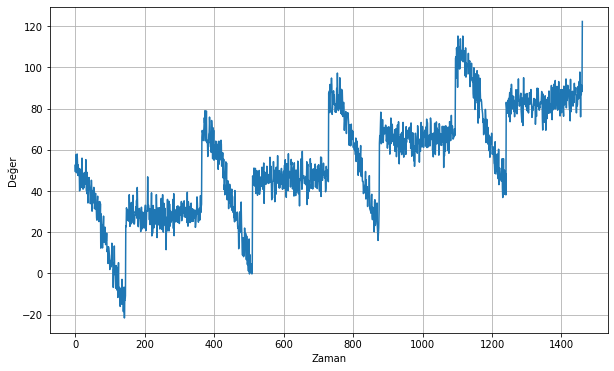

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN ile Tahmin Yapılması

`keras.backend.clear_session()`: Kerasın arka uç oturumlarını temizler. tf.`random.set_seed(42)` ve `np.random.seed(42)` : Kodun her çalıştığında aynı çıktıyı vermesini sağlar = Tekrarlanabilirlik sağlar.

Sonra oluşturduğumuz modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın `LearningRateScheduler` işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur.


Bununla beraber her yenileme (epoch) başında modelin durumunun sıfırlanması gereklidir. Bunun için keras.callbacks.Callback sınıfını kullanarak kendi sınıfımızı oluşturuyoruz. fit yöntemi içerisinde bulunan callbacks listesine de eklememiz gerektiğini unutmayalım.




In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 8s 15ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 14ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 14ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:




(1e-08, 0.0001, 0.0, 30.0)

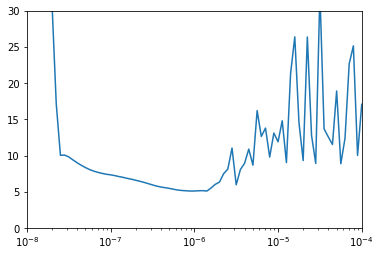

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])


Grafiği incelediğimizde en uygun değerin 5e-7 olacağını kabul edebiliriz. 1e-6 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (epochs) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

`early_stopping` gibi bize yardımcı olabilecek bir diğer `callbacks` çeşidi `model_checkpoint`'dir. Kayıt notları (`model_checkpoint`) model eğitilirken modelin durumunun iyiye gittiği her yineleme sonrası modeli bir kayıt noktası olarak kaydeder. Eğitim tamamlandığında en iyi modeli seçerek kullanabiliriz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bununla beraber her yenileme (epoch) başında modelin durumunun sıfırlanması gereklidir. Bunun için `keras.callbacks.Callback` sınıfını kullanarak kendi sınıfımızı oluşturmuştuk. `fit` yöntemi içerisinde bulunan `callbacks` listesine de eklememiz gerektiğini unutmayalım.


Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde callbacks listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak `epochs` değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.



In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
33/33 [==============================] - 4s 41ms/step - loss: 30.0122 - mae: 30.5051 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 17ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

Görüldüğü gibi erken durdurma işlevimiz 417. yinelemeden sonra modelimizin eğitimini durdurdu. Ve eğitim süresi diğer modellere kıyasla oldukça uzun sürdü

En iyi modelimizi seçmek için `keras.models.load_model` işlevini kullanıyoruz ve en başarılı modelimizi `model` adlı değişkene atıyoruz.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (`model_forecast`) oluşturuyoruz.

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

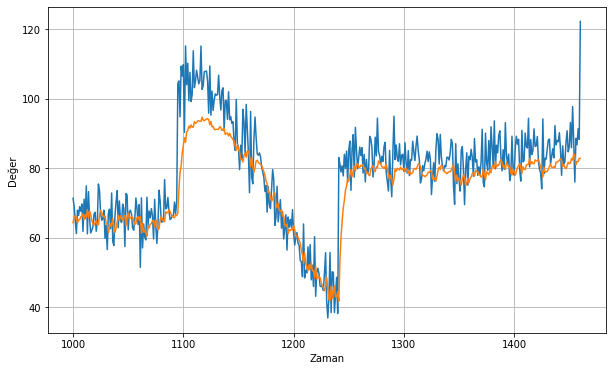

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Modelimizin performansını ölçelim ve ortalama mutlak hata (`mae`) değerimizi bulalım.

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.971135